Sprint 深層学習スクラッチ ディープニューラルネットワーク
---

In [104]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [105]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

データセットの確認
---

In [106]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


平滑化
---

In [107]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print(X_train[100, :])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2  18  46 136 136 244 255 241 103   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  15  94 163 253 253 253 253 238 218
 204  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 131 253 253 253 253 237 200  57   0   0   0   

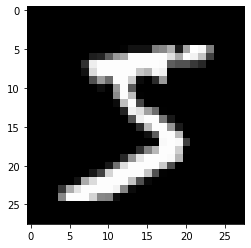

In [108]:
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')

前処理(フロート)
---

In [109]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


OneHotencoder
---

sparse
===
transform、fit_transformの実行結果の型を指定する。デフォルト値はTrue。
・True : 2次元のscipy.sparse.csr.csr_matrix
・False : 2次元のnumpy.ndarray

handle_unknown
===
※1に記載した部分の挙動に影響する。デフォルト値は'error'。
'error'：※1のケースにて、処理が異常終了する。
'ignore'：※1のケースにて、categories[i]に含まれていないカテゴリ値を無視する。

In [110]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:,np.newaxis])
y_test_one_hot = enc.transform(y_test[:,np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


テストスピリットを行う
---

In [111]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train_.shape) # (48000, 784)
print("X_val.shape =", X_val.shape) # (12000, 784)
print("y_train.shape =", y_train_.shape) # (48000, 784)
print("y_val.shape =", y_val.shape) # (12000, 784)

X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


ニューラルネットワークスクラッチ
----

【問題１】全結合層のクラス化
---

In [112]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, Optimizer):
        self.optimizer = Optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X@self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

In [113]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma*np.random.randn(n_nodes2)
        return B


【問題3】最適化手法のクラス化
---
>最適化手法のクラス化を行なってください。
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。
これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [114]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -=self.lr*layer.dW
        layer.B -=self.lr*layer.dB
        return

【問題4】活性化関数のクラス化
---
>活性化関数のクラス化を行なってください。
ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

>発展的要素:
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。



In [115]:
class ActSigmoid:
    def forward(self,A):
        return self.sigmoid(A)
    
    def backword(self, dZ):
        _sig=self.sigmoid(self.A)
        return dZ*(1-_sig)*_sig
    
    def sigmoid(self, X):
        return 1/(1+np.exp(-X))

In [116]:
class ActTanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

In [117]:
class ActSoftmax:
    def forward(self, X):
        self.Z = np.exp(X)/np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z

    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z-Y
    
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))
    

【問題5】ReLUクラスの作成
---
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。


\[f(x) = ReLU(x) = \begin{cases} x & \text{if $x>0$,}\\ 0 & \text{if $x\leqq0$.} \end{cases}\]
$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。


$\[\frac{\partial f(x)}{\partial x} = \begin{cases} 1 & \text{if $x>0$,}\\ 0 & \text{if $x\leqq0$.} \end{cases}\]$
数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [118]:
class ActReUL:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ*np.clip(np.sigh(self.A),0,None)
    
#clipの使い方 https://note.nkmk.me/python-numpy-clip/
#sighの使い方 https://note.nkmk.me/python-numpy-sign-signbit-copysign/

【問題6】重みの初期値
---
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

In [119]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [120]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

【問題7】最適化手法
---
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。
まず、これまで使ってきたSGDを確認します。

$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$

In [121]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB +=layer.dB**2
        layer.W -= self.lr*np.sqrt(1/self.HW)*layer.dW
        layer.B -= self.lr*np.sqrt(1/self.HB)*layer.dB

In [158]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True, Activater=ActTanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.Activater = Activater
        
        if Activater == ActSigmoid or Activater == ActTanh:
            self.Initializer = XavierInitializer
        elif Activater == ActReLU:
            self.Initializer = HeInitializer
        else:
            print("活性化関数が不適切")
        self.Optimizer = Optimizer
        
        # 正解率を出力
    def accuracy(self, y, z):
        return (z.argmax(axis=1) == y).sum()
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
    
#       optimizer = SGD(self.lr)
        #インスタンス化
        self.FC1 = FC(self.n_features, self.n_nodes1, self.Initializer(), self.Optimizer(self.lr))
        self.activation1 = self.Activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = ActSoftmax()
        
        
        #Lossの更新
        self.loss=[]
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
        
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
        
        #イテレーションごとのフォーワード
    def forward_propagation(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
        #イテレーションごとのバックワード
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
        
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label="train_loss")
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label="epoch_loss")
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()
        return
    

In [159]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [160]:
def evaluate(y_true, y_pred):
    print("accuracy =", accuracy_score(y_true, y_pred))
    print("precision =", precision_score(y_true, y_pred, average='macro'))
    print("recall =", recall_score(y_true, y_pred, average='macro'))
    print("f1 =", f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))

In [161]:
scratch_dnn1 = ScratchDeepNeuralNetrowkClassifier(num_epoch=5, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=ActTanh, Optimizer=SGD)
scratch_dnn1.fit(X_train_, y_train_)

In [162]:
y_pred1 = scratch_dnn1.predict(X_test)

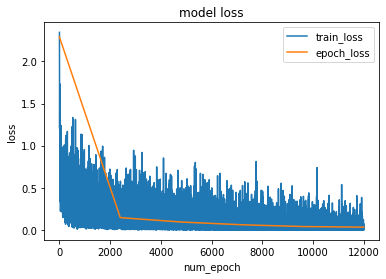

accuracy = 0.9719
precision = 0.9722827815959801
recall = 0.9715629496241134
f1 = 0.9717596877810639
[[ 964    0    2    2    0    1    5    1    3    2]
 [   0 1118    3    5    1    1    2    0    4    1]
 [   2    0 1013    4    1    0    3    2    7    0]
 [   0    0    6  990    1    2    0    1    5    5]
 [   0    0    6    1  954    0    3    3    2   13]
 [   4    0    1   23    1  843    7    0    7    6]
 [   5    3    1    1    1    2  942    0    3    0]
 [   0    7   18   10    2    0    0  973    1   17]
 [   1    1    4   10    2    1    2    0  953    0]
 [   2    2    1    8   11    2    1    5    8  969]]


In [165]:
scratch_dnn1.learning_curve()
evaluate(y_test, y_pred1)


scratch_dnn3(num_epoch=20, lr=1e-2, Activater=ActTanh, Optimizer=SGD

In [156]:
scratch_dnn3 = ScratchDeepNeuralNetrowkClassifier(num_epoch=20, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=ActTanh, Optimizer=SGD)
scratch_dnn3.fit(X_train_, y_train_)

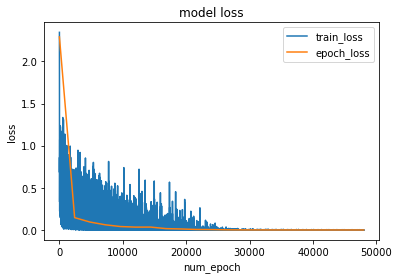

accuracy = 0.9813
precision = 0.9811792105418246
recall = 0.9810858733375587
f1 = 0.9811277268623458
[[ 974    0    1    0    0    1    3    1    0    0]
 [   0 1129    1    2    0    1    0    1    1    0]
 [   3    0 1012    2    1    0    3    5    6    0]
 [   1    0    5  989    0    4    0    5    2    4]
 [   0    0    3    0  963    0    3    3    1    9]
 [   3    0    0    3    2  871    5    1    3    4]
 [   4    1    1    1    3    4  939    0    5    0]
 [   1    4    9    1    0    0    0 1007    1    5]
 [   2    0    4    5    1    4    2    5  949    2]
 [   1    2    1    7   10    2    0    3    3  980]]


In [166]:
scratch_dnn3.learning_curve()
y_pred3 = scratch_dnn3.predict(X_test)
evaluate(y_test, y_pred3)